In [15]:
import cv2
import os

In [16]:
def get_v_data(v: cv2.VideoCapture):
    return {
        "fps": round(v.get(cv2.CAP_PROP_FPS)),
        "total_f": v.get(cv2.CAP_PROP_FRAME_COUNT)
	}

In [17]:
video_root = './v'
data_root = './bad_frames'

if not os.path.exists(data_root):
    os.makedirs(data_root)

img size: 1280 * 720

In [18]:
W = 1280
H = 720

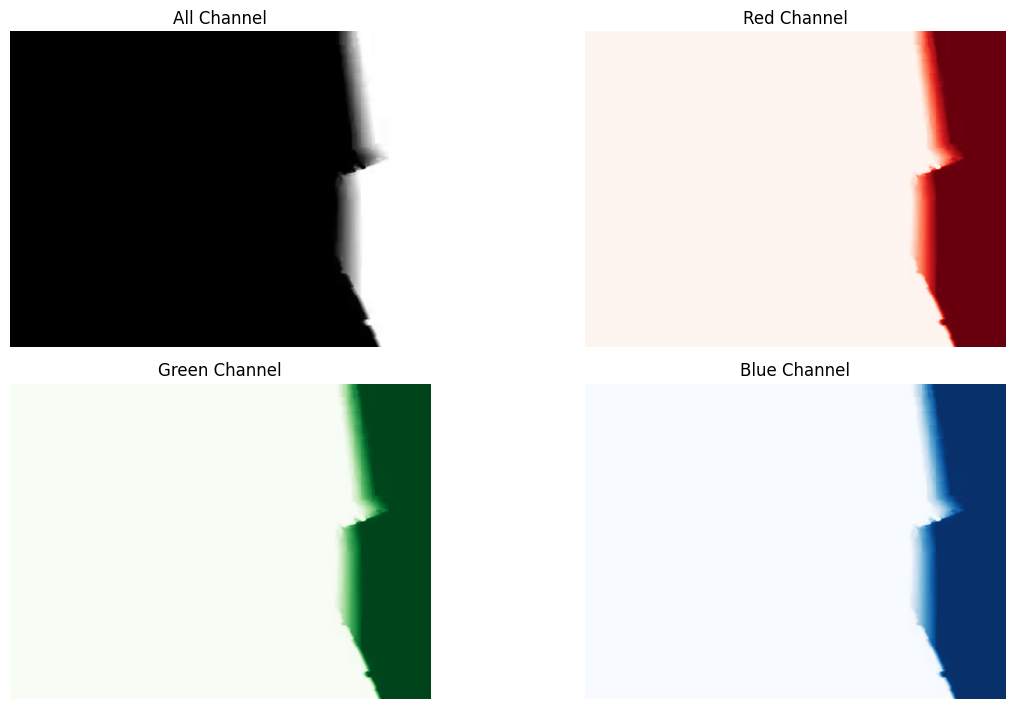

In [19]:
import cv2
import matplotlib.pyplot as plt

# Load an image using OpenCV
image = cv2.imread("./bad_frames/50.jpg")  # Replace with the path to your image

# Convert the image from BGR (OpenCV format) to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Split the image into R, G, B channels
R, G, B = cv2.split(image_rgb)

# Set up the subplots for each channel
fig, axes = plt.subplots(2, 2, figsize=(12.8, 7.2))

axes[0, 0].imshow(image_rgb)
axes[0, 0].set_title("All Channel")
axes[0, 0].axis("off")

# Plot each channel separately
axes[0, 1].imshow(R, cmap="Reds")
axes[0, 1].set_title("Red Channel")
axes[0, 1].axis("off")

axes[1, 0].imshow(G, cmap="Greens")
axes[1, 0].set_title("Green Channel")
axes[1, 0].axis("off")

axes[1, 1].imshow(B, cmap="Blues")
axes[1, 1].set_title("Blue Channel")
axes[1, 1].axis("off")

# Display the plots
plt.tight_layout()
plt.show()


In [20]:
import numpy as np

print(R)
print(np.mean(R))
print(np.mean(G))
print(np.mean(B))

[[  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 ...
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]]
45.216712962962966
45.216712962962966
45.216712962962966


In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt

# 色彩特徵維度較低
grey_bins = 16   # RGB 各通道 4 分區，共 64 維
edge_bins = 16           # 輪廓方向分成 16 區
edge_weight = 2.0        # 邊緣特徵的權重


avr_RGB_data = {}
for serial in tqdm(range(40, 6515, 5)):
	image = cv2.imread(f"{data_root}/{serial}.jpg")
	gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

	# ===== 🎨 顏色特徵 (RGB 3D Histogram) =====
	hist = cv2.calcHist([gray], [0], None, [grey_bins], [0, 256])  # 分成 16 bins 
	hist = cv2.normalize(hist, hist).flatten()  # shape: (grey_bins,)

	# ===== 📐 邊緣方向特徵 (Gradient Orientation Histogram) =====
	sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
	sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
	magnitude = np.sqrt(sobelx**2 + sobely**2)
	orientation = np.arctan2(sobely, sobelx)  # [-π, π]

	# 計算方向分布直方圖（以 magnitude 加權）
	orientation_hist, _ = np.histogram(
		orientation,
		bins=edge_bins,
		range=(-np.pi, np.pi),
		weights=magnitude
	)
	orientation_hist = orientation_hist / (np.sum(orientation_hist) + 1e-5)  # normalize

	# 合併特徵向量
	combined_feature = np.concatenate([
		hist,
		orientation_hist * edge_weight
	])  # shape: grey_bins + edge_bins = 32

	avr_RGB_data[serial] = combined_feature.tolist()


100%|██████████| 1295/1295 [00:10<00:00, 119.59it/s]


In [22]:
import json

obj = json.dumps(avr_RGB_data, indent=2)
with open("./BAD_grey_edge.json", 'w+', encoding='utf-8') as f:
	f.write(obj)